# Thrombin ligands for pharmacophore identification

We explore thrombing ligands that will be used to create ligand-based pharmacophore models

In [1]:
import openpharmacophore as oph

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import nglview as nv

from collections import defaultdict
from pprint import pprint

from IPython.display import SVG

## Load  and visualize ligands

We load the ligands from their respective smiles and draw their molecular structures

In [2]:
lig_df = pd.read_csv("ligands.csv")
lig_df

,Smiles,PDBID,LigID
0,[H]/N=C(\C1CCC(CC1)CNC(=O)[C@@H]2C=C(CN3N2C(=O...,1C4V,IH2
1,CN[C@H](Cc1ccccc1)C(=O)N2CCC[C@H]2C(=O)NCC3CCC...,1TOM,MIN
2,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D6W,00R
3,c1ccc(cc1)S(=O)(=O)CCN2C(=O)N3CC=C[C@H](N3C2=O...,1D91,00P
4,[H]/N=C(/c1ccc(cc1)C[C@H](C(=O)N2CCCCC2)NC(=O)...,1DWD,MID
5,[H]/N=C(\c1ccc2c(c1)cc([nH]2)C(=O)N3CCC(CC3)Cc...,1D4P,BPP


In [3]:
def load_ligands():
    """ Load the ligands into a list of rdkit molecules."""
    ligands = []
    
    smiles = lig_df["Smiles"]
    pdb_ids = lig_df["PDBID"]
    
    for ii in range(len(smiles)):
        mol = Chem.MolFromSmiles(smiles[ii].encode("unicode_escape"))
        mol.SetProp("_Name", pdb_ids[ii])
        assert mol is not None
        ligands.append(mol)
    
    supp = Chem.SDMolSupplier("0ZI.sdf")
    mol = next(supp)
    mol.RemoveAllConformers()
    mol.SetProp("_Name", "1FPC")
    ligands.append(mol)

    print(f"Num ligands: {len(ligands)}")
    return ligands

Num ligands: 7


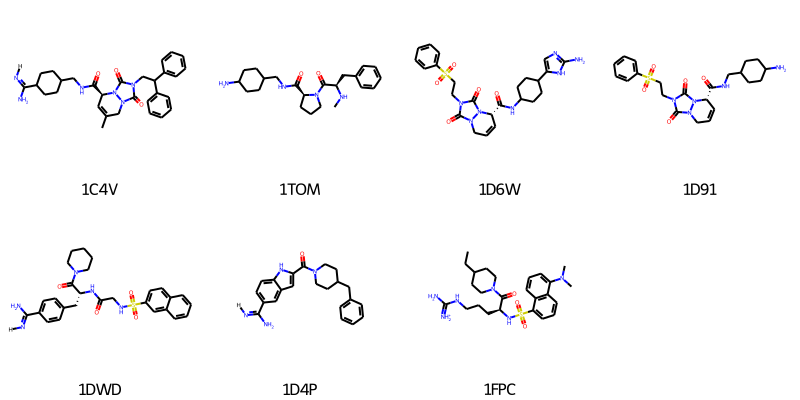

In [4]:
ligands = load_ligands()
legends = [l.GetProp("_Name") for l in ligands]
Draw.MolsToGridImage(ligands, legends=legends, molsPerRow=4)

## Preparing the ligands

We'll generate different conformers for each of the ligands and add hydrogens to them
as well.

In [5]:
pharmacophore = oph.LigandBasedPharmacophore()
pharmacophore.ligands = ligands

### Generating conformers

In [6]:
pharmacophore.generate_conformers(n_confs=-1, ligands="all")
print([l.GetNumConformers() for l in pharmacophore.ligands])

[178, 171, 164, 153, 170, 42, 281]


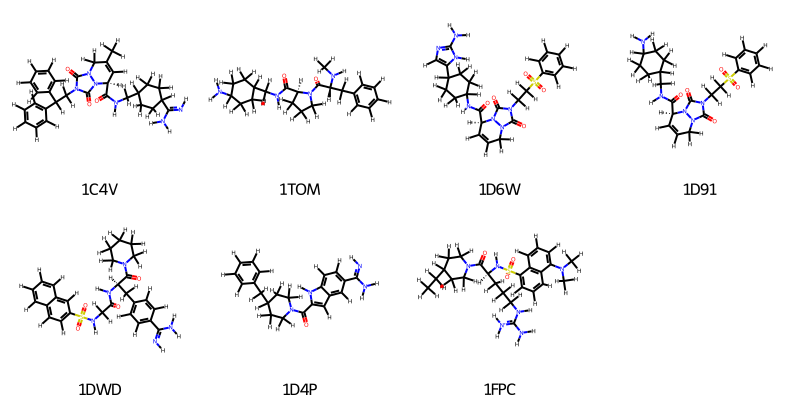

In [7]:
ligs_no_conf = [
    Chem.Mol(lig) for lig in pharmacophore.ligands
]
for lig in ligs_no_conf:
    lig.RemoveAllConformers()
Draw.MolsToGridImage(ligs_no_conf, legends=legends, molsPerRow=4)

## View 3D structures

In [8]:
lig_ind = 2
conf_ind = 2
nv.show_rdkit(pharmacophore.ligands[lig_ind], conf_ind=conf_ind)

NGLWidget()

## Chemical features

We find chemical features in the ligands and visualize them.

In [9]:
pharmacophore.find_chem_feats()
pprint(pharmacophore.feats)

[{'A': [(12,), (20,), (23,)],
  'D': [(1,), (10,), (39,)],
  'H': [(3, 4, 5, 6, 7, 8), (38,)],
  'N': [],
  'P': [(2, 1, 39)],
  'R': [(17, 18, 19, 21, 22),
        (26, 27, 28, 29, 30, 31),
        (32, 33, 34, 35, 36, 37)]},
 {'A': [(1,), (27,), (11,), (18,)],
  'D': [(1,), (19,), (27,)],
  'H': [(21, 22, 23, 24, 25, 26), (13, 14, 15), (0,)],
  'N': [],
  'P': [(1,), (27,)],
  'R': [(4, 5, 6, 7, 8, 9)]},
 {'A': [(33,), (7,), (8,), (13,), (21,), (23,)],
  'D': [(24,), (35,), (36,)],
  'H': [(25, 26, 27, 28, 29, 30), (15, 16, 17)],
  'N': [],
  'P': [],
  'R': [(11, 12, 14, 19, 20), (31, 32, 33, 34, 35), (0, 1, 2, 3, 4, 5)]},
 {'A': [(32,), (7,), (8,), (13,), (21,), (23,)],
  'D': [(24,), (32,)],
  'H': [(26, 27, 28, 29, 30, 31), (15, 16, 17)],
  'N': [],
  'P': [(32,)],
  'R': [(11, 12, 14, 19, 20), (0, 1, 2, 3, 4, 5)]},
 {'A': [(1,), (12,), (21,), (25,), (26,)],
  'D': [(1,), (19,), (23,), (37,)],
  'H': [(14, 15, 16), (18, 17, 16)],
  'N': [],
  'P': [(2, 1, 37)],
  'R': [(3, 4, 5, 

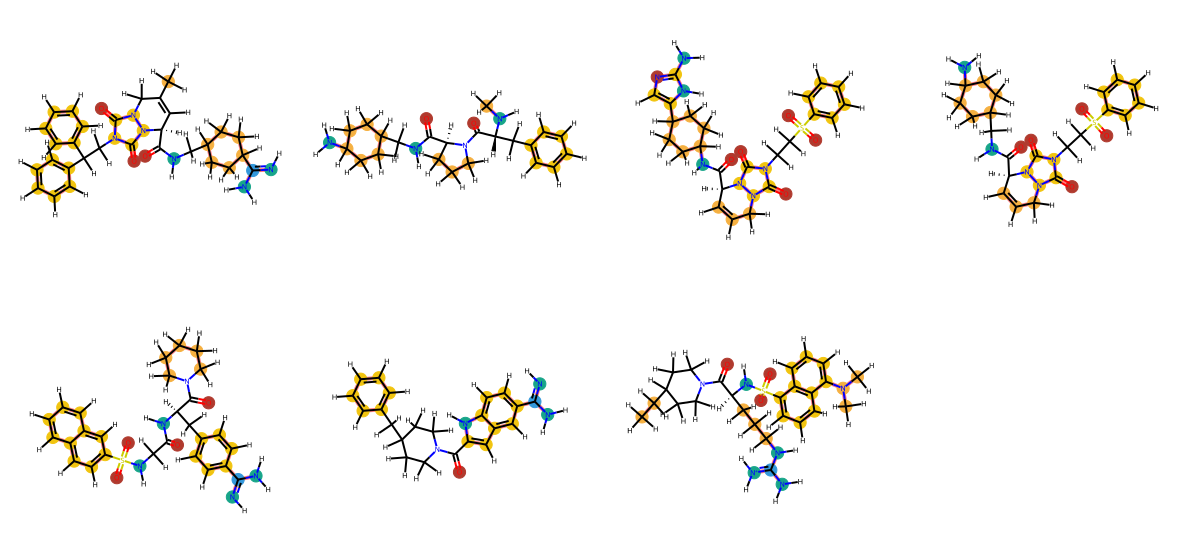

In [10]:
drawing = pharmacophore.draw((300, 280))
SVG(drawing.GetDrawingText())

## Extracting common pharmacophores

We extract common pharmacophores via recursive distance partitioning algorithm

In [11]:
import openpharmacophore.pharmacophore.ligand_based.rdp as rdp

In [12]:
ligands = []
for ii, lig in enumerate(pharmacophore.ligands):
    lig = rdp.Ligand(lig, pharmacophore.feats[ii])
    lig._update_variant()
    ligands.append(lig)
    print(f"Ligand {legends[ii]} has variant {lig.variant}")

Ligand 1C4V has variant AAADDDHHPRRR
Ligand 1TOM has variant AAAADDDHHHPPR
Ligand 1D6W has variant AAAAAADDDHHRRR
Ligand 1D91 has variant AAAAAADDHHPRR
Ligand 1DWD has variant AAAAADDDDHHPRRR
Ligand 1D4P has variant AADDDPRRR
Ligand 1FPC has variant AAADDDDHHHHPPRR


### Finding K-Point Pharmacophores

In [13]:
min_actives = len(pharmacophore.ligands)
n_points = 3
k_variants = rdp.common_k_point_variants(ligands, n_points, min_actives)

In [14]:
print(f"There are {len(k_variants)} variants of {n_points} points")

There are 666 variants of 3 points


In [15]:
containers = rdp.common_k_point_feature_lists(ligands, k_variants)

print(f"There are {len(containers)} containers")
for c in containers:
    print(f"Container {c.variant} has {len(c)} feat lists")

There are 5 containers
Container AAD has 26948 feat lists
Container AAR has 21510 feat lists
Container ADD has 17934 feat lists
Container ADR has 37086 feat lists
Container DDR has 10707 feat lists


In [16]:
boxes = {}

for cont in containers:
    boxes[cont.variant] = rdp.pharmacophore_partitioning(cont, min_actives)

for var, cont_lists in boxes.items():
    print(f"Variant {var} has {len(cont_lists)} surviving boxes")

Variant AAD has 0 surviving boxes
Variant AAR has 0 surviving boxes
Variant ADD has 13 surviving boxes
Variant ADR has 98 surviving boxes
Variant DDR has 13 surviving boxes


In [17]:
boxes_add = boxes["ADD"]
feat_lists = []

for box in boxes_add:
    scores = rdp.score_common_pharmacophores(box)
    if len(scores) > 0:
        top = scores[0]
        feat_lists.append(box[top[1]])

feat_lists

In [18]:
fl = feat_lists[0] 
points = rdp.feat_list_to_pharma(fl, ligands[fl.id[0]])
view = nv.show_rdkit(
    pharmacophore.ligands[fl.id[0]], conf_id=fl.id[1])
for p in points:
    p.add_to_ngl_view(view)
view

NGLWidget()